In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
from tqdm import tqdm
from rl_glue import RLGlue

import torch
import torch.nn as nn
import torch.optim as optim
import random

from collections import deque

from tbu_gym.tbu_discrete import TruckBackerEnv_D

In [15]:
import random
from collections import deque
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class QRCAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        lr=1e-3,
        gamma=0.99,
        lam=0.9,                # kept for API compatibility (not used here)
        epsilon=1.0,
        epsilon_decay=0.995,
        min_epsilon=0.01,
        buffer_size=50000,
        batch_size=64,
        beta=1.0,               # regularization strength for h (matches JAX self.beta)
        device=None,
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.lam = lam
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.beta = beta

        # Replay memory
        self.memory = deque(maxlen=buffer_size)

        # Device
        self.device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

        # Networks
        self.q_net = self.build_nn(output_dim=self.action_dim).to(self.device)
        self.target_net = self.build_nn(output_dim=self.action_dim).to(self.device)
        self.h_net = self.build_nn(output_dim=self.action_dim).to(self.device)

        # init target
        self.target_net.load_state_dict(self.q_net.state_dict())

        # Optimizers
        self.q_optimizer = optim.Adam(self.q_net.parameters(), lr=self.lr)
        self.h_optimizer = optim.Adam(self.h_net.parameters(), lr=self.lr)

        # Steps counter
        self.steps = 0

    def build_nn(self, output_dim):
        """2 hidden layers with 128 neurons each"""
        return nn.Sequential(
            nn.Linear(self.state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def agent_policy(self, state):
        """Epsilon-greedy policy returning an int action"""
        if np.random.rand() < self.epsilon:
            return int(np.random.randint(self.action_dim))
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.q_net(state)
        return int(q_values.argmax(dim=1).item())

    def remember(self, state, action, reward, next_state, done):
        """Store transition tuple"""
        self.memory.append((state, action, reward, next_state, done))

    def train_with_mem(self):
        """Train using experience replay. Returns total loss (q_loss + h_loss) for logging."""
        if len(self.memory) < self.batch_size:
            return 0.0

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.stack(states), dtype=torch.float32).to(self.device)         # (B, state_dim)
        next_states = torch.tensor(np.stack(next_states), dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(self.device)     # (B,1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)  # (B,1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)      # (B,1)

        # Current Q for taken actions (B,1)
        q_all = self.q_net(states)                                  # (B, A)
        q_values = q_all.gather(1, actions)                         # (B,1)

        # h-values for taken actions (B,1)
        h_all = self.h_net(states)
        h_values = h_all.gather(1, actions)                         # (B,1)

        # Next-state greedy value (use target_net), detach it
        with torch.no_grad():
            next_q_all = self.target_net(next_states)               # (B,A)
            # greedy next action value: max_a Q'(s', a)
            vtp1 = next_q_all.max(dim=1, keepdim=True)[0]          # (B,1)
            vtp1 = vtp1.detach()

            # Q target (standard Q-learning greedy target)
            target = rewards + self.gamma * vtp1 * (1.0 - dones)   # (B,1)
            target = target.detach()

        # TD error (not detached yet)
        delta = target - q_values                                   # (B,1)

        # Build v_loss and h_loss per-sample exactly like JAX:
        # v_loss_i = 0.5 * delta^2 + gamma * stop_gradient(delta_hat) * vtp1
        # h_loss_i = 0.5 * (stop_gradient(delta) - delta_hat)^2
        v_loss_terms = 0.5 * (delta ** 2) + self.gamma * h_values.detach() * vtp1
        h_loss_terms = 0.5 * (delta.detach() - h_values) ** 2

        v_loss = v_loss_terms.mean()
        h_loss = h_loss_terms.mean()

        # --- Update Q-network (q_net) ---
        self.q_optimizer.zero_grad()
        v_loss.backward(retain_graph=True)   # retain_graph because h_loss backward next might need graph if shared (here nets separate so optional)
        self.q_optimizer.step()

        # --- Update h-network (h_net) ---
        self.h_optimizer.zero_grad()
        h_loss.backward()
        self.h_optimizer.step()

        # --- Apply explicit decay / regularization on h parameters (beta term) ---
        # This approximates: params_h <- params_h - stepsize * beta * params_h
        # i.e. multiplicative shrinkage: p *= (1 - lr * beta)
        if self.beta != 0.0:
            decay_factor = 1.0 - (self.lr * self.beta)
            # clamp decay_factor to a sensible positive number
            decay_factor = max(decay_factor, 0.0)
            with torch.no_grad():
                for p in self.h_net.parameters():
                    p.mul_(decay_factor)

        # Decay epsilon
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay
            if self.epsilon < self.min_epsilon:
                self.epsilon = self.min_epsilon

        total_loss = v_loss.item() + h_loss.item()
        return total_loss

    def update_target(self):
        """Hard update target network weights from q_net"""
        self.target_net.load_state_dict(self.q_net.state_dict())

In [16]:
# --- 1. Hyperparameters ---

num_episodes = 1000
max_steps_per_episode = 500
gamma = 0.99
learning_rate = 1e-3
epsilon_start = 1.0
epsilon_decay = 0.99997
epsilon_min = 0.01
batch_size = 64
target_update_freq = 5  # Update target net every few episodes

# QRC Specific Parameters
alpha = 1.0
sigma_min = 0.0
sigma_max = 1.0

Episode    1/1000, Reward: -300.00, Epsilon: 0.99292, Loss: 0.01179
Episode    2/1000, Reward: -300.00, Epsilon: 0.98402, Loss: 0.00272
Episode    3/1000, Reward: -300.00, Epsilon: 0.97520, Loss: 0.00267
Episode    4/1000, Reward: -300.00, Epsilon: 0.96646, Loss: 0.00983
Episode    5/1000, Reward: -300.00, Epsilon: 0.95781, Loss: 0.01048
Episode    6/1000, Reward: -300.00, Epsilon: 0.94922, Loss: 0.00330
Episode    7/1000, Reward: -300.00, Epsilon: 0.94072, Loss: 0.01222
Episode    8/1000, Reward: -300.00, Epsilon: 0.93229, Loss: 0.00164
Episode    9/1000, Reward: -300.00, Epsilon: 0.92394, Loss: 0.02460
Episode   10/1000, Reward: -300.00, Epsilon: 0.91566, Loss: 0.01312
Episode   11/1000, Reward: -300.00, Epsilon: 0.90745, Loss: 0.05615
Episode   12/1000, Reward: -300.00, Epsilon: 0.89932, Loss: 0.00444
Episode   13/1000, Reward: -300.00, Epsilon: 0.89127, Loss: 0.00514
Episode   14/1000, Reward: -300.00, Epsilon: 0.88328, Loss: 0.00603
Episode   15/1000, Reward: -300.00, Epsilon: 0.8

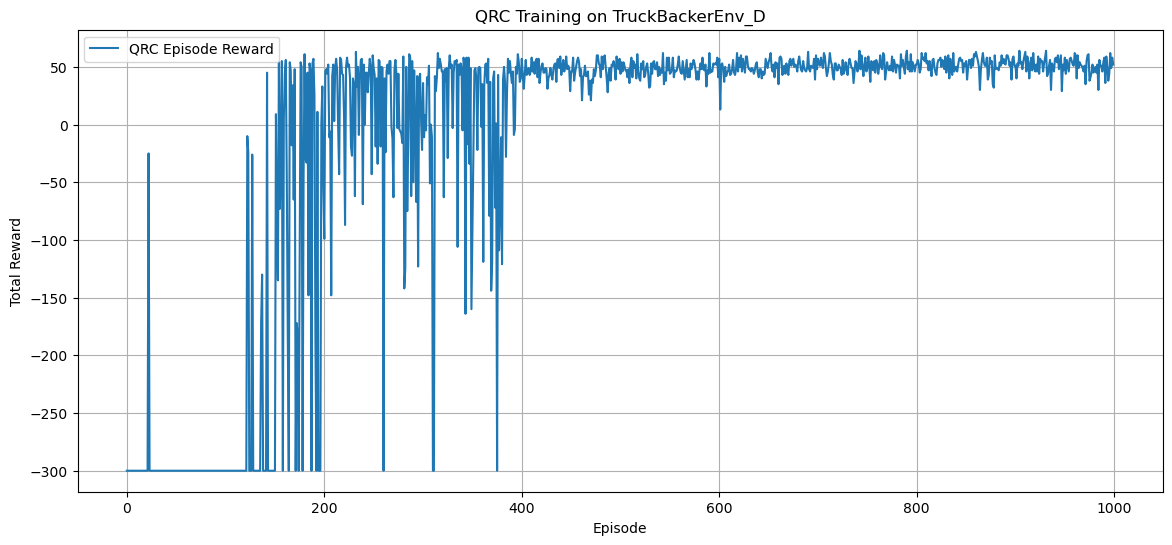

In [18]:
# --- 2. Environment Setup ---
env = TruckBackerEnv_D(render_mode=None)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# --- 3. Agent Initialization ---
agent = QRCAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    lr=learning_rate,
    gamma=gamma,
    epsilon=epsilon_start,
    epsilon_decay=epsilon_decay,
    min_epsilon=epsilon_min,
    batch_size=batch_size
)

# --- 4. Training Loop ---
episode_rewards = []
recent_loss = 0.0

for episode in range(1, num_episodes + 1):
    reset_output = env.reset()
    if isinstance(reset_output, tuple):
        state, _ = reset_output
    else:
        state = reset_output

    total_reward = 0

    for t in range(max_steps_per_episode):
        # Select action
        action = agent.agent_policy(state)

        # Step environment (compatible with Gym / Gymnasium)
        step_result = env.step(action)
        if len(step_result) == 5:
            next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated
        else:
            next_state, reward, done, _ = step_result

        total_reward += reward

        # Store transition and train
        agent.remember(state, action, reward, next_state, done)
        loss = agent.train_with_mem()
        if loss != 0.0:
            recent_loss = loss

        state = next_state
        if done:
            break

    # Update target network every few episodes
    if episode % target_update_freq == 0:
        agent.update_target()

    # Record and print progress
    episode_rewards.append(total_reward)
    print(f"Episode {episode:4d}/{num_episodes}, Reward: {total_reward:7.2f}, "
          f"Epsilon: {agent.epsilon:.5f}, Loss: {recent_loss:.5f}")

# --- 5. Plotting Results ---
plt.figure(figsize=(14, 6))
plt.plot(episode_rewards, label="QRC Episode Reward")
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('QRC Training on TruckBackerEnv_D')
plt.legend()
plt.grid(True)
plt.savefig('QRC_Discrete_TruckBackerEnv_D.png', dpi=300, bbox_inches='tight')
plt.show()

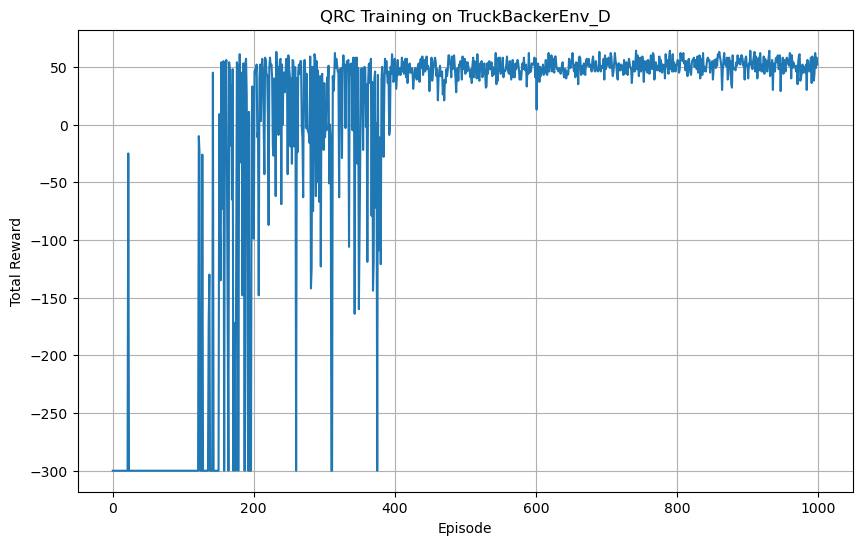

In [19]:
# Plotting Results
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('QRC Training on TruckBackerEnv_D')
plt.grid(True)

# Save the plot to a file
plt.savefig('QRC_Discrete_TruckBackerEnv_D.png', dpi=300, bbox_inches='tight')

plt.show()

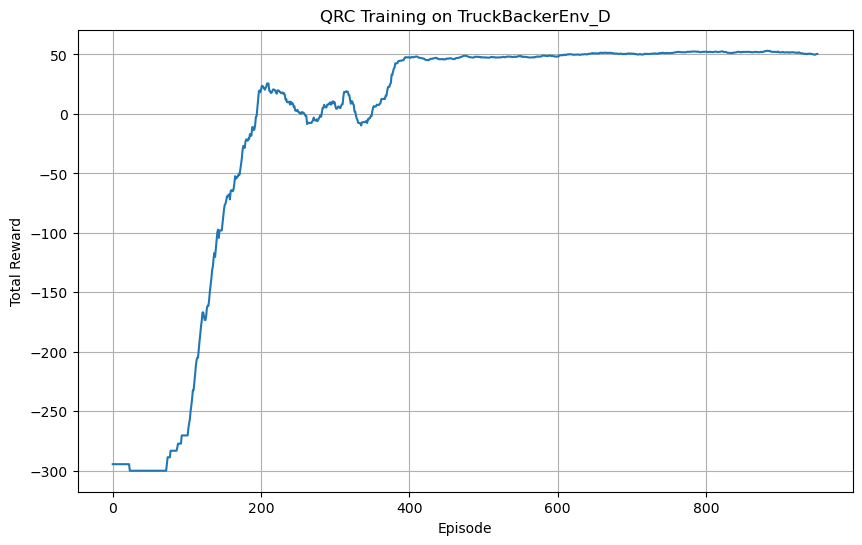

In [20]:
window = 50
smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')

# Plotting Results
plt.figure(figsize=(10, 6))
# plt.plot(episode_rewards)
plt.plot(smoothed)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('QRC Training on TruckBackerEnv_D')
plt.grid(True)

# Save the plot to a file
plt.savefig('QRC_Discrete_TruckBackerEnv_D.png', dpi=300, bbox_inches='tight')

plt.show()